In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, sgd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from matplotlib import pyplot as plt
import numpy as np
import time
import pandas as pd
from collections import defaultdict
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
from PIL import Image
import time

In [2]:
import nltk

def sbleu(GT,PRED):
    score = 0
    for i in range(len(GT)):
        Lgt = len(GT[i].split(' '))
        if Lgt > 4 :
            cscore = nltk.translate.bleu_score.sentence_bleu([GT[i].split(' ')],PRED[i].split(' '),weights=(0.25,0.25,0.25,0.25),smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method4)
        else:
            weight_lst = tuple([1.0/Lgt]*Lgt)
            cscore = nltk.translate.bleu_score.sentence_bleu([GT[i].split(' ')],PRED[i].split(' '),weights=weight_lst,smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method4)
        score += cscore
    return score/(len(GT))

In [3]:
def make_vocabulary(paths):
    vocab = defaultdict(lambda : -1)
    vocab["[PAD]"] = 0
    vocab["<SOS>"] = 1
    vocab["<EOS>"] = 2
    run_index = 3
    for file in paths:
        csv_file = pd.read_csv(file)
        for formula in csv_file['formula'].values:
            formula_split = formula.split()
            for character in formula_split:
                if character not in vocab:
                    vocab[character] = run_index
                    run_index += 1
    return vocab

def load_data(path_to_images, path_to_csv, vocabulary, max_length_formula = 128):
    images = []
    labels = []
    lengths = []
    trans = transforms.ToTensor()
    label_csv = pd.read_csv(path_to_csv)
    label_split = [label_csv.iloc[i]['formula'].split() for i in range(len(label_csv))]
    print(len(label_split))
    x = [True if len(label) <= max_length_formula-2 else False for label in label_split]
    label_csv = label_csv.loc[x]
    label_split2 = label_split
    label_split = []
    for label in label_split2:
        if len(label) <= max_length_formula-2:
            label_split.append(label)
    t = time.time()
    images = ([(trans(Image.open(os.path.join(path_to_images, fname)).resize((224, 224)))) for fname in label_csv['image']])
    print(f"Images done in :{time.time() -t:.3}s")
    lengths = np.array([len(label)+2 for label in label_split])
    labels = np.zeros((len(label_split), max_length_formula))
    labels[:,0] = vocabulary['<SOS>']
    for i in range(len(label_split)):
        labels[i,1:len(label_split[i])+1] = np.array([vocabulary[char] for char in label_split[i]])
        labels[i,len(label_split[i])+1] = vocabulary['<EOS>']
    return images, labels, vocabulary, lengths

class image_latex_dataset2(torch.utils.data.Dataset):

    def __init__(self, images, labels, vocabulary, lengths, max_length_formula = 128):
        self.images, self.labels, self.vocabulary, self.lengths = images, labels, vocabulary, lengths
        self.inverse_vocabulary = {v:k for k,v in self.vocabulary.items()}

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if self.images[idx].shape[0] == 1:
            self.images[idx] = torch.cat((self.images[idx], self.images[idx], self.images[idx]), dim=0)
        return self.images[idx], self.labels[idx], self.lengths[idx]

In [9]:
vocab_train = make_vocabulary(['col_774_A4_2023/SyntheticData/train.csv','col_774_A4_2023/HandwrittenData/train_hw.csv'])

In [4]:
t = time.time()
train_data_load = load_data('col_774_A4_2023/SyntheticData/images','col_774_A4_2023/SyntheticData/train.csv',vocab_train)
print(time.time() -t)
train_data2 = image_latex_dataset2(train_data_load[0],train_data_load[1],train_data_load[2],train_data_load[3])

75000
Images done in :9.25e+02s
928.3354773521423


In [10]:
vocab_test = make_vocabulary(['col_774_A4_2023/SyntheticData/test.csv'])
vocab_val = make_vocabulary(['col_774_A4_2023/SyntheticData/val.csv'])

In [5]:
t = time.time()
vocab_test = make_vocabulary(['col_774_A4_2023/SyntheticData/test.csv'])
test_data_load = load_data('col_774_A4_2023/SyntheticData/images','col_774_A4_2023/SyntheticData/test.csv',vocab_test)
print(time.time() -t)
test_data2 = image_latex_dataset2(test_data_load[0],test_data_load[1],test_data_load[2],test_data_load[3])

8907
Images done in :1.02e+02s
103.16875624656677


In [6]:
t = time.time()
vocab_val = make_vocabulary(['col_774_A4_2023/SyntheticData/val.csv'])
val_data_load = load_data('col_774_A4_2023/SyntheticData/images','col_774_A4_2023/SyntheticData/val.csv',vocab_val)
print(time.time() -t)
val_data2 = image_latex_dataset2(val_data_load[0],val_data_load[1],val_data_load[2],val_data_load[3])

10000
Images done in :1.13e+02s
113.32148313522339


In [9]:
test_loader2 = DataLoader(test_data2, batch_size=128, shuffle=True)
train_loader2 = DataLoader(train_data2, batch_size=128, shuffle=True)
val_loader2 = DataLoader(val_data2, batch_size=128, shuffle=True)

In [5]:
t = time.time()
train_data_loadHw = load_data('col_774_A4_2023/HandwrittenData/images/train','col_774_A4_2023/HandwrittenData/train_hw.csv',vocab_train)
print(time.time() -t)
train_dataHw = image_latex_dataset2(train_data_loadHw[0],train_data_loadHw[1],train_data_loadHw[2],train_data_loadHw[3])

9000
Images done in :2.75e+02s
275.1583273410797


In [6]:
train_loader_hw = DataLoader(train_dataHw, batch_size = 128, shuffle = True)

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.cnn = torch.load('resnest50.model')

    def forward(self, image):
        # get the 3D feature map from image
        feature_map = (self.cnn(image))
        return feature_map
    
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, num_layers, vocabulary, max_seq_length=128):

        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size * 2 + 1000 , hidden_size, num_layers = num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.relu = nn.ReLU()
        self.attention = BahdanauAttention(hidden_size)

        self.max_seg_length = max_seq_length
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.vocab = dict(vocabulary)

    def forward(self, encoder_outputs, target_tensor=None, teacher_forcing_prob = 0.5):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(self.vocab["<SOS>"])
        decoder_hidden = (encoder_outputs.view(1,encoder_outputs.shape[0],encoder_outputs.shape[1]),encoder_outputs.view(1,encoder_outputs.shape[0],encoder_outputs.shape[1]))
        decoder_outputs = []
        attentions = []

        for i in range(self.max_seg_length):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if torch.rand(1).item() > teacher_forcing_prob :
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_repr):
        embedded =  (self.embedding(input))
        query = hidden[0].permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_repr.unsqueeze(1))
        input_lstm = torch.cat((embedded, context), dim=-1)
        input_lstm = torch.concat((encoder_repr.unsqueeze(1), input_lstm), dim=-1)

        output, hidden = self.lstm(input_lstm, hidden)
        output = self.out(output)

        return output, hidden, attn_weights
    
    
class LatexNet_ResNest(nn.Module):

    def __init__(self,hidden_size, vocab_size, num_layers, vocabulary, max_seq_length=128):
        #hidden_size == embed_size
        super(LatexNet_ResNest, self).__init__()
        self.encoder = Encoder()
        self.decoder = AttnDecoderRNN(hidden_size, vocab_size, num_layers, vocabulary, max_seq_length)
    
    def forward(self, image, formula = None, teacher_forcing_prob = 0.5):
        encoder_outputs = self.encoder(image)
        decoder_outputs, decoder_hidden, _ = self.decoder(encoder_outputs, formula, teacher_forcing_prob)
        return decoder_outputs, decoder_hidden, encoder_outputs
    def predict(self,image):
        encoder_outputs = self.encoder(image.to(device))
        decoder_outputs, decoder_hidden, _ = self.decoder(encoder_outputs, teacher_forcing_prob = 0)
        return decoder_outputs.argmax(-1), decoder_outputs
        

In [207]:
model = LatexNet_ResNest(1000, len(vocab_train), 1, vocab_train)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index = 0)
model.to(device)
model.train()

LatexNet_ResNest(
  (encoder): Encoder(
    (cnn): ResNet(
      (conv1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64,

In [116]:
#training loop
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
path = f'LatexNet_ResNest{dt_string}'
os.mkdir(path)
prev_loss = float('inf')
stochastic_losses_pre = []
use_adaptive_tf = False
print(f"Saving models to {path}")
teacher_forcing_prob = 0.5

Saving models to LatexNet_ResNest28_11_2023_06_50_01


In [208]:
model.load_state_dict(torch.load('LatexNet_ResNest28_11_2023_06_50_01/model_train_50.pth')())

<All keys matched successfully>

In [117]:
for epoch in range(1,31):
    model.train()
    epoch_train_loss = []
    epoch_time = time.time()
    for i, (imgs, labls, lenghts) in enumerate(train_loader2):
        imgs = imgs.to(device)
        labls = labls.long().to(device)
        optimizer.zero_grad()
        decoderOutput, decoderHidden, encoderOutput = model(imgs, labls, teacher_forcing_prob)
        decoderOutput.shape
        loss = criterion(decoderOutput.reshape(-1, len(vocab_train)), labls.long().reshape(-1))
        loss.backward()
        epoch_train_loss.append(loss.item())
        stochastic_losses_pre.append(loss.item())
        optimizer.step()
        if i % 100 == 0:
            plt.figure(figsize=(30,18))
            plt.plot(stochastic_losses_pre)
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.legend(["Training Loss"])
            plt.savefig("StochasticLoss_res_nest_pre.png")
            print("Epoch: {} Iteration: {} Loss: {}".format(epoch, i, loss.item()))
            plt.close()
    torch.save(model.state_dict, os.path.join(path,f'model_train_{epoch}.pth'))
    print("Epoch: {} Loss: {} Time :{} | TFP : ".format(epoch, np.mean(epoch_train_loss), time.time() -epoch_time), teacher_forcing_prob)

Epoch: 1 Iteration: 0 Loss: 6.345348834991455
Epoch: 1 Iteration: 100 Loss: 2.963925361633301
Epoch: 1 Iteration: 200 Loss: 2.8343257904052734
Epoch: 1 Iteration: 300 Loss: 3.018749713897705
Epoch: 1 Iteration: 400 Loss: 2.8437678813934326
Epoch: 1 Iteration: 500 Loss: 2.706573724746704
Epoch: 1 Loss: 2.8985530347154853 Time :241.83149361610413 | TFP :  0.5
Epoch: 2 Iteration: 0 Loss: 2.7041406631469727
Epoch: 2 Iteration: 100 Loss: 2.8310632705688477
Epoch: 2 Iteration: 200 Loss: 2.6673572063446045
Epoch: 2 Iteration: 300 Loss: 2.6060006618499756
Epoch: 2 Iteration: 400 Loss: 2.396406650543213
Epoch: 2 Iteration: 500 Loss: 2.5522072315216064
Epoch: 2 Loss: 2.519090329136765 Time :236.9727966785431 | TFP :  0.5
Epoch: 3 Iteration: 0 Loss: 2.4396915435791016
Epoch: 3 Iteration: 100 Loss: 2.258505344390869
Epoch: 3 Iteration: 200 Loss: 2.302051067352295
Epoch: 3 Iteration: 300 Loss: 2.3687620162963867
Epoch: 3 Iteration: 400 Loss: 2.186333417892456
Epoch: 3 Iteration: 500 Loss: 2.1215524

In [118]:
for epoch in range(31,51):
    model.train()
    epoch_train_loss = []
    epoch_time = time.time()
    for i, (imgs, labls, lenghts) in enumerate(train_loader2):
        imgs = imgs.to(device)
        labls = labls.long().to(device)
        optimizer.zero_grad()
        decoderOutput, decoderHidden, encoderOutput = model(imgs, labls, teacher_forcing_prob)
        decoderOutput.shape
        loss = criterion(decoderOutput.reshape(-1, len(vocab_train)), labls.long().reshape(-1))
        loss.backward()
        epoch_train_loss.append(loss.item())
        stochastic_losses_pre.append(loss.item())
        optimizer.step()
        if i % 100 == 0:
            plt.figure(figsize=(30,18))
            plt.plot(stochastic_losses_pre)
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.legend(["Training Loss"])
            plt.savefig("StochasticLoss_res_nest_pre.png")
            print("Epoch: {} Iteration: {} Loss: {}".format(epoch, i, loss.item()))
            plt.close()
    torch.save(model.state_dict, os.path.join(path,f'model_train_{epoch}.pth'))
    print("Epoch: {} Loss: {} Time :{} | TFP : ".format(epoch, np.mean(epoch_train_loss), time.time() -epoch_time), teacher_forcing_prob)

Epoch: 31 Iteration: 0 Loss: 0.9998890161514282
Epoch: 31 Iteration: 100 Loss: 0.951555609703064
Epoch: 31 Iteration: 200 Loss: 0.9960027933120728
Epoch: 31 Iteration: 300 Loss: 1.0230929851531982
Epoch: 31 Iteration: 400 Loss: 1.0016751289367676
Epoch: 31 Iteration: 500 Loss: 0.9423544406890869
Epoch: 31 Loss: 0.9554784571915342 Time :249.46481251716614 | TFP :  0.5
Epoch: 32 Iteration: 0 Loss: 0.8357774615287781
Epoch: 32 Iteration: 100 Loss: 1.0206687450408936
Epoch: 32 Iteration: 200 Loss: 1.04771089553833
Epoch: 32 Iteration: 300 Loss: 0.8164812326431274
Epoch: 32 Iteration: 400 Loss: 0.7976416945457458
Epoch: 32 Iteration: 500 Loss: 1.0046738386154175
Epoch: 32 Loss: 0.9455544482197678 Time :238.20776176452637 | TFP :  0.5
Epoch: 33 Iteration: 0 Loss: 0.8387405276298523
Epoch: 33 Iteration: 100 Loss: 0.9121478796005249
Epoch: 33 Iteration: 200 Loss: 0.7699112296104431
Epoch: 33 Iteration: 300 Loss: 0.8510218858718872
Epoch: 33 Iteration: 400 Loss: 1.2586983442306519
Epoch: 33 Ite

In [209]:
for epoch in range(51,71):
    model.train()
    epoch_train_loss = []
    epoch_time = time.time()
    for i, (imgs, labls, lenghts) in enumerate(train_loader2):
        imgs = imgs.to(device)
        labls = labls.long().to(device)
        optimizer.zero_grad()
        decoderOutput, decoderHidden, encoderOutput = model(imgs, labls, teacher_forcing_prob)
        decoderOutput.shape
        loss = criterion(decoderOutput.reshape(-1, len(vocab_train)), labls.long().reshape(-1))
        loss.backward()
        epoch_train_loss.append(loss.item())
        stochastic_losses_pre.append(loss.item())
        optimizer.step()
        if i % 100 == 0:
            plt.figure(figsize=(30,18))
            plt.plot(stochastic_losses_pre)
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.legend(["Training Loss"])
            plt.savefig("StochasticLoss_res_nest_pre.png")
            print("Epoch: {} Iteration: {} Loss: {}".format(epoch, i, loss.item()))
            plt.close()
    torch.save(model.state_dict, os.path.join(path,f'model_train_{epoch}.pth'))
    print("Epoch: {} Loss: {} Time :{} | TFP : ".format(epoch, np.mean(epoch_train_loss), time.time() -epoch_time), teacher_forcing_prob)

Epoch: 51 Iteration: 0 Loss: 0.54375821352005
Epoch: 51 Iteration: 100 Loss: 0.7141927480697632
Epoch: 51 Iteration: 200 Loss: 0.8619831204414368
Epoch: 51 Iteration: 300 Loss: 0.7144241333007812
Epoch: 51 Iteration: 400 Loss: 0.6674538850784302
Epoch: 51 Iteration: 500 Loss: 0.6373907327651978
Epoch: 51 Loss: 0.7122803068474719 Time :258.35734844207764 | TFP :  0.5
Epoch: 52 Iteration: 0 Loss: 0.5901797413825989
Epoch: 52 Iteration: 100 Loss: 0.7047052383422852
Epoch: 52 Iteration: 200 Loss: 0.6923611164093018
Epoch: 52 Iteration: 300 Loss: 0.6372691988945007
Epoch: 52 Iteration: 400 Loss: 0.670971691608429
Epoch: 52 Iteration: 500 Loss: 1.0510507822036743
Epoch: 52 Loss: 0.6977822233710372 Time :255.00580263137817 | TFP :  0.5
Epoch: 53 Iteration: 0 Loss: 0.5777080059051514
Epoch: 53 Iteration: 100 Loss: 0.7135522365570068
Epoch: 53 Iteration: 200 Loss: 0.6683805584907532
Epoch: 53 Iteration: 300 Loss: 0.6073713898658752
Epoch: 53 Iteration: 400 Loss: 0.7536553144454956
Epoch: 53 Ite

In [210]:
modelTest = LatexNet_ResNest(1000, len(vocab_train), 1, vocab_train)

In [211]:
modelTest.load_state_dict(torch.load('LatexNet_ResNest28_11_2023_06_50_01/model_train_70.pth')())

<All keys matched successfully>

In [11]:
test_vocab_inverse = {v:k for (k,v) in vocab_test.items()}
train_vocab_inverse = {v:k for (k,v) in vocab_train.items()}
val_vocab_inverse = {v:k for (k,v) in vocab_val.items()}

In [212]:
modelTest.eval()
modelTest.to(device)
predict_test = []
true_out_test = []
img_c_test = []
for data in test_loader2:
    decoder_outputs = modelTest.forward(data[0].to(device),teacher_forcing_prob =1)[0].argmax(dim = -1)
    for sent,true_sent,img in zip(decoder_outputs,data[1],data[0]):
        s = []
        img_c_test.append(img)
        for i in sent[1:]:
            if train_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(train_vocab_inverse[i.item()])
        predict_test.append(' '.join(s))
        s = []
        for i in true_sent:
            if test_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(test_vocab_inverse[i.item()])
        true_out_test.append(' '.join(s[1:]))
        

print("Macro Bleu for Test Data set: ", sbleu(true_out_test, predict_test))

Macro Bleu for Test Data set:  0.5934028810733367


$ S _ { L } ( g , \sigma ) = \int d ^ { 2 } x \sqrt { g } ( { \frac { 1 } { 2 } } g ^ { \alpha \beta } \partial _ { \alpha } \sigma \partial _ { \beta } \sigma + \sigma R ) $
$ S _ { L } ( \sigma , g ) = \int d ^ { 2 } x \sqrt g ( \frac { 1 } { 2 } g ^ { \alpha \beta } \partial _ { \alpha } \sigma \partial _ { \beta } \sigma + R \sigma ) $


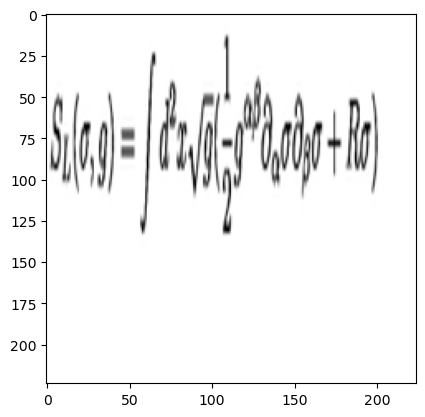

In [214]:
j = 1500
print(predict_test[j])
print(true_out_test[j])
plt.imshow(img_c_test[j].permute(1,2,0))

In [215]:
predict_val = []
true_out_val = []
img_c_val = []
for data in val_loader2:
    decoder_outputs = modelTest.forward(data[0].to(device),teacher_forcing_prob =1)[0].argmax(dim = -1)
    for sent,true_sent,img in zip(decoder_outputs,data[1],data[0]):
        s = []
        img_c_val.append(img)
        for i in sent[1:]:
            if train_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(train_vocab_inverse[i.item()])
        predict_val.append(' '.join(s))
        s = []
        for i in true_sent:
            if val_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(val_vocab_inverse[i.item()])
        true_out_val.append(' '.join(s[1:]))
        

print("Macro Bleu for Valdiation Data set: ", sbleu(true_out_val, predict_val))

Macro Bleu for Valdiation Data set:  0.5886993914108429


$ \hat { H } = \frac 1 2 ( D _ { a } ^ { a } } - B _ { a _ ^ { a } } ) - ^ { b } ( - B _ { a b } ^ { b } ) - C _ { n _ { b } } ^ { b } ( B ^ { b } - - ) , $
$ \hat { H } = \frac { 1 } { 2 } ( p _ { n _ { a } } ^ { a } - B ^ { a } ) A _ { a b } ( - ) ^ { \epsilon _ { b } } ( p _ { n _ { b } } ^ { b } - B ^ { b } ) - C , $


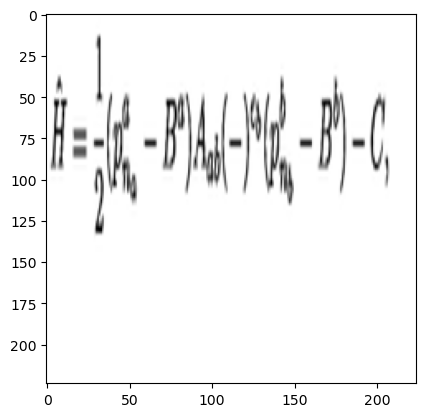

In [216]:
j = 157
print(predict_val[j])
print(true_out_val[j])
plt.imshow(img_c_val[j].permute(1,2,0))

In [217]:
predict_train = []
true_out_train = []
img_c_train = []
for data in train_loader2:
    decoder_outputs = modelTest.forward(data[0].to(device),teacher_forcing_prob =1)[0].argmax(dim = -1)
    for sent,true_sent,img in zip(decoder_outputs,data[1],data[0]):
        s = []
        img_c_train.append(img)
        for i in sent[1:]:
            if train_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(train_vocab_inverse[i.item()])
        predict_train.append(' '.join(s))
        s = []
        for i in true_sent:
            if train_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(train_vocab_inverse[i.item()])
        true_out_train.append(' '.join(s[1:]))
        
print("Macro Bleu over train: ", sbleu(true_out_train, predict_train))

Macro Bleu over train:  0.817805417633399


0.755 Old
70 epoch 

In [14]:
t = time.time()
vocab_val_hw  = make_vocabulary(['col_774_A4_2023/HandwrittenData/val_hw.csv'])
val_data_load_hw = load_data('col_774_A4_2023/HandwrittenData/images/train','col_774_A4_2023/HandwrittenData/val_hw.csv',vocab_val_hw,128)
print(time.time() -t)
val_dataHW = image_latex_dataset2(val_data_load_hw[0],val_data_load_hw[1],val_data_load_hw[2],val_data_load_hw[3])
vocab_val_hw_inv = {v:k for (k,v) in vocab_val_hw.items()}

1000
Images done in :31.5s
31.576221227645874


In [168]:
val_hw_loader = DataLoader(val_dataHW, batch_size=128, shuffle=True)
for loop_var in range(51,71):
    modelTest.load_state_dict(torch.load(f'LatexNet_ResNest28_11_2023_06_50_01/model_train_{loop_var}.pth')())
    modelTest.eval()
    modelTest.to(device)
    predict_hw_val = []
    true_out_hw_val = []
    img_c_hw_val = []
    for data in val_hw_loader:
        decoder_outputs = modelTest.forward(data[0].to(device),teacher_forcing_prob =1)[0].argmax(dim = -1)
        for sent,true_sent,img in zip(decoder_outputs,data[1],data[0]):
            s = []
            img_c_hw_val.append(img)
            for i in sent[1:]:
                if train_vocab_inverse[i.item()] == "<EOS>":
                    break
                s.append(train_vocab_inverse[i.item()])
            predict_hw_val.append(' '.join(s))
            s = []
            for i in true_sent:
                if vocab_val_hw_inv[i.item()] == "<EOS>":
                    break
                s.append(vocab_val_hw_inv[i.item()])
            true_out_hw_val.append(' '.join(s[1:]))
    print(f"Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : {loop_var}: ",sbleu(true_out_hw_val, predict_hw_val))

Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 1:  0.009174007383859295
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 2:  0.00888319446518709
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 3:  0.01190112825611021
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 4:  0.006283642328789445
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 5:  0.0075939869539593755
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 6:  0.005142080603289748
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 7:  0.006828818628966681
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 8:  0.009365448158728964
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 9:  0.007115024805105572
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 10:  0.0062291507386776045
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 11:  0.00607215093697003
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 12: 

In [218]:
val_hw_loader = DataLoader(val_dataHW, batch_size=128, shuffle=True)
for loop_var in range(51,71):
    modelTest.load_state_dict(torch.load(f'LatexNet_ResNest28_11_2023_06_50_01/model_train_{loop_var}.pth')())
    modelTest.eval()
    modelTest.to(device)
    predict_hw_val = []
    true_out_hw_val = []
    img_c_hw_val = []
    for data in val_hw_loader:
        decoder_outputs = modelTest.forward(data[0].to(device),teacher_forcing_prob =1)[0].argmax(dim = -1)
        for sent,true_sent,img in zip(decoder_outputs,data[1],data[0]):
            s = []
            img_c_hw_val.append(img)
            for i in sent[1:]:
                if train_vocab_inverse[i.item()] == "<EOS>":
                    break
                s.append(train_vocab_inverse[i.item()])
            predict_hw_val.append(' '.join(s))
            s = []
            for i in true_sent:
                if vocab_val_hw_inv[i.item()] == "<EOS>":
                    break
                s.append(vocab_val_hw_inv[i.item()])
            true_out_hw_val.append(' '.join(s[1:]))
    print(f"Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : {loop_var}: ",sbleu(true_out_hw_val, predict_hw_val))

Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 51:  0.013537058718380925
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 52:  0.01105629686637433
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 53:  0.0066230535941210695
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 54:  0.010895375880260587
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 55:  0.009900943060042258
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 56:  0.008785531304556294
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 57:  0.012682457539997078
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 58:  0.01099964023309578
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 59:  0.012119084903684314
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 60:  0.010777900497045476
Macro Bleu Over HW Validations Set w/o fine-tuning :Epoch : 61:  0.012585207552375634
Macro Bleu Over HW Validations Set w/o fine-tuning :Epo

In [54]:
t = time.time()
train_data_loadHw = load_data('col_774_A4_2023/HandwrittenData/images/train','col_774_A4_2023/HandwrittenData/train_hw.csv',vocab_train)
print(time.time() -t)
train_dataHw = image_latex_dataset2(train_data_loadHw[0],train_data_loadHw[1],train_data_loadHw[2],train_data_loadHw[3])

9000
Images done in :1.24e+02s
124.31722068786621


In [62]:
train_dataHw = image_latex_dataset2(train_data_loadHw[0],train_data_loadHw[1],train_data_loadHw[2],train_data_loadHw[3])
train_loader_hw = DataLoader(train_dataHw, batch_size = 128, shuffle = True)

In [219]:
LatxResNetFine = LatexNet_ResNest(1000, len(vocab_train), 1, vocab_train)
LatxResNetFine.load_state_dict(torch.load('LatexNet_ResNest28_11_2023_06_50_01/model_train_68.pth')())

<All keys matched successfully>

In [220]:
#training loop
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
path_hw = f'LatexNetFine_Res_68_{dt_string}'
os.mkdir(path_hw)
prev_loss = float('inf')
stochastic_losses = []
best_val_loss = float('inf')
epoch_val_loss = []
use_adaptive_tf = False
print(f"Saving models to {path_hw}")
teacher_forcing_prob = 0.5

Saving models to LatexNetFine_Res_68_28_11_2023_16_02_19


In [221]:
optimizer_hw = Adam(LatxResNetFine.parameters(), lr=0.001)
criterion_hw = nn.CrossEntropyLoss(ignore_index = 0)
LatxResNetFine.to(device)
LatxResNetFine.train()

LatexNet_ResNest(
  (encoder): Encoder(
    (cnn): ResNet(
      (conv1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64,

In [222]:
#LatxResNetFine.load_state_dict(torch.load(f'LatexNetFine_Res_42_28_11_2023_12_17_16/model_train_fine_{25}.pth')())
for epoch in range(1,51):
    LatxResNetFine.train()
    epoch_train_loss = []
    epoch_time = time.time()
    for i, (imgs, labls, lenghts) in enumerate(train_loader_hw):
        imgs = imgs.to(device)
        labls = labls.long().to(device)
        optimizer_hw.zero_grad()
        decoderOutput, decoderHidden, encoderOutput = LatxResNetFine(imgs, labls, teacher_forcing_prob)
        decoderOutput.shape
        loss = criterion_hw(decoderOutput.reshape(-1, len(vocab_train)), labls.long().reshape(-1))
        loss.backward()
        epoch_train_loss.append(loss.item())
        stochastic_losses.append(loss.item())
        optimizer_hw.step()
        if i % 100 == 0:
            plt.figure(figsize=(30,18))
            plt.plot(stochastic_losses)
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.legend(["Training Loss"])
            plt.savefig("StochasticLoss_hw.png")
            print("Epoch: {} Iteration: {} Loss: {}".format(epoch, i, loss.item()))
            plt.close()
    torch.save(LatxResNetFine.state_dict, os.path.join(path_hw,f'model_train_fine_{epoch}.pth'))

    print("Epoch: {} Loss: {} Time :{} | TFP : ".format(epoch, np.mean(epoch_train_loss), time.time() -epoch_time), teacher_forcing_prob)

Epoch: 1 Iteration: 0 Loss: 8.326396942138672
Epoch: 1 Loss: 3.2058993930548008 Time :32.42878198623657 | TFP :  0.5
Epoch: 2 Iteration: 0 Loss: 2.427614212036133
Epoch: 2 Loss: 2.3072012662887573 Time :31.939440727233887 | TFP :  0.5
Epoch: 3 Iteration: 0 Loss: 2.051753282546997
Epoch: 3 Loss: 1.9099562957253255 Time :32.268271923065186 | TFP :  0.5
Epoch: 4 Iteration: 0 Loss: 1.616164207458496
Epoch: 4 Loss: 1.5623824764305436 Time :31.979466199874878 | TFP :  0.5
Epoch: 5 Iteration: 0 Loss: 1.4740254878997803
Epoch: 5 Loss: 1.3140024567993593 Time :31.949876308441162 | TFP :  0.5
Epoch: 6 Iteration: 0 Loss: 1.2775501012802124
Epoch: 6 Loss: 1.1024898567669827 Time :31.968769311904907 | TFP :  0.5
Epoch: 7 Iteration: 0 Loss: 0.8710647821426392
Epoch: 7 Loss: 0.9211679747406866 Time :31.95076036453247 | TFP :  0.5
Epoch: 8 Iteration: 0 Loss: 0.7698580026626587
Epoch: 8 Loss: 0.7788689883661942 Time :32.53146696090698 | TFP :  0.5
Epoch: 9 Iteration: 0 Loss: 0.7321575880050659
Epoch: 9

KeyboardInterrupt: 

In [229]:
del LatxResNetFine
torch.cuda.empty_cache()

LatexNetFine_Res_42_28_11_2023_12_17_16/ : PRe-train : 25 : best result for fine-tune epoch 24 (avoid overfitting with decent score)

LatexNetFine_Res_68_28_11_2023_16_02_19 : 68 Epoch pre trained rest fine tune

In [15]:
LatxResNetFine = LatexNet_ResNest(1000, len(vocab_train), 1, vocab_train)

In [16]:

val_hw_loader = DataLoader(val_dataHW, batch_size=128, shuffle=True)
for loop_var in range(1,43):
    LatxResNetFine.load_state_dict(torch.load(f'LatexNetFine_Res_68_28_11_2023_16_02_19/model_train_fine_{loop_var}.pth')())
    LatxResNetFine.eval()
    LatxResNetFine.to(device)
    predict_hw_val = []
    true_out_hw_val = []
    img_c_hw_val = []
    for data in val_hw_loader:
        decoder_outputs = LatxResNetFine.forward(data[0].to(device),teacher_forcing_prob =1)[0].argmax(dim = -1)
        for sent,true_sent,img in zip(decoder_outputs,data[1],data[0]):
            s = []
            img_c_hw_val.append(img)
            for i in sent[1:]:
                if train_vocab_inverse[i.item()] == "<EOS>":
                    break
                s.append(train_vocab_inverse[i.item()])
            predict_hw_val.append(' '.join(s))
            s = []
            for i in true_sent:
                if vocab_val_hw_inv[i.item()] == "<EOS>":
                    break
                s.append(vocab_val_hw_inv[i.item()])
            true_out_hw_val.append(' '.join(s[1:]))

    print(f"Macro Bleu Over HW Validations Set with fine-tuning steps {loop_var}: ", sbleu(true_out_hw_val, predict_hw_val))

Macro Bleu Over HW Validations Set with fine-tuning steps 1:  0.07293277764359905
Macro Bleu Over HW Validations Set with fine-tuning steps 2:  0.14390010195029454
Macro Bleu Over HW Validations Set with fine-tuning steps 3:  0.22416052869713923
Macro Bleu Over HW Validations Set with fine-tuning steps 4:  0.26526637133593955
Macro Bleu Over HW Validations Set with fine-tuning steps 5:  0.3546043440965318
Macro Bleu Over HW Validations Set with fine-tuning steps 6:  0.28088487072223667
Macro Bleu Over HW Validations Set with fine-tuning steps 7:  0.4053011054330945
Macro Bleu Over HW Validations Set with fine-tuning steps 8:  0.4332076129159438
Macro Bleu Over HW Validations Set with fine-tuning steps 9:  0.44491379815584264
Macro Bleu Over HW Validations Set with fine-tuning steps 10:  0.43881711543913116
Macro Bleu Over HW Validations Set with fine-tuning steps 11:  0.46876080108547086
Macro Bleu Over HW Validations Set with fine-tuning steps 12:  0.42221569843287493
Macro Bleu Over 

Val Macro Bleu:
but predicr usin 10-15 fine tuning epochs only
20 -> 0.69
21 -> 0.678
22 -> 0.697
23 -> 0.694
24 -> 0.697
- 25 -> 0.703
26 -> 0.6944
27 -> 0.7011
28 -> 

Pre-trained 50 epochs:
fine tune : 20 : 0.6536

LatexNetFine_Res_42_28_11_2023_12_17_16/ : PRe-train : 25 : best result for fine-tune epoch 24 (avoid overfitting with decent score)

LatexNetFine_Res_68_28_11_2023_16_02_19 : 68 Epoch pre trained rest fine tune 33


In [141]:
print(predict_hw_val[0])
print()
print(true_out_hw_val[0])

$ x ^ \prime = x \cos \theta + y \sin \theta $

$ x ^ \prime = x \cos \theta + y \sin \theta $


In [30]:
LatxResNetFine.load_state_dict(torch.load(f'LatexNetFine_Res_68_28_11_2023_16_02_19/model_train_fine_{17}.pth')())

<All keys matched successfully>

In [31]:
def load_data_subHW(path_to_images, path_to_csv):
    images = []
    index = []
    trans = transforms.ToTensor()
    label_csv = pd.read_csv(path_to_csv)
    images = ([(trans(Image.open(os.path.join(path_to_images, fname)).resize((224, 224)))) for fname in label_csv['image']])
    for i in range(len(images)):
        if images[i].shape[0] == 1:
            images[i] = torch.cat([images[i], images[i], images[i]], dim = 0)
    return images

In [20]:
t = time.time()
sub_dataHW = load_data_subHW('col_774_A4_2023/HandwrittenData/images/test','sample_sub.csv')
print(time.time() -t)

128.27750158309937


In [32]:
testHW_Loader = DataLoader(sub_dataHW, batch_size=128, shuffle=False)
LatxResNetFine.max_seg_length = 1000
predict = []
true_out = []
img_c = []
for data in testHW_Loader:
    decoder_outputs = LatxResNetFine.forward(data.to(device),teacher_forcing_prob =1)[0].argmax(dim = -1)
    for i,sent in enumerate(decoder_outputs):
        s = []
        img_c.append(data[i])
        for i in sent[1:]:
            if train_vocab_inverse[i.item()] == "<EOS>":
                break
            s.append(train_vocab_inverse[i.item()])
        predict.append(' '.join(s))

In [33]:
csv = pd.read_csv('sample_sub.csv')
new_dict = {'image':[], 'formula':[]}
for i in range(len(predict)):
    new_dict['image'].append(csv['image'][i])
    new_dict['formula'].append(predict[i])
new_pd = pd.DataFrame(new_dict)
new_pd.to_csv('preds/sample_sub_comp25f_gbleu_68_pre_17fine.csv', index = False)

In [34]:
new_pd

,image,formula
0,81-1312-200924.png,$ { \sqrt { 3 } } ^ { \mbox { B } } $
1,1698881946969636953.png,$ s _ s = 2 $
2,rM3DfB510.png,$ \lim _ { x \rightarrow \infty } c ^ { x } = ...
3,em_UN_103_56.png,$ \cos a = a _ 2 $
4,1698881946969702936.png,$ h ( 1 ) = f $
...,...,...
4247,formulaire016-equation031.png,$ \alpha x ^ { 2 } + 1 ^ p = 1 $
4248,MfrDB2822.png,$ \sqrt { \frac { 1 } { n } ^ { 2 } } } { ( \f...
4249,formulaire009-equation058.png,$ \phi ( _ _ { ( 1 ) = 1 $
4250,formulaire002-equation058.png,$ \frac { x _ 2 y _ 1 - x _ 1 } { x _ 1 } $


$ { { \mbox { I } - \mbox { C } } $


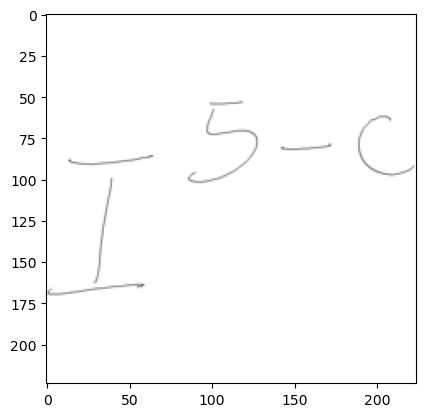

In [36]:
j = 83
print(new_pd['formula'][j])
plt.imshow(img_c[j].permute(1,2,0))

In [39]:
!pip show nltk

Name: nltk
Version: 3.8.1
Summary: Natural Language Toolkit
Home-page: https://www.nltk.org/
Author: NLTK Team
Author-email: nltk.team@gmail.com
License: Apache License, Version 2.0
Location: /home/maths/btech/mt1210236/anaconda3/lib/python3.11/site-packages
Requires: click, joblib, regex, tqdm
Required-by: 
